# augmentation을 적용한 함수 dl모델을 제작

데이터 증강 함수
- A.Resize(height=256, width=256) : 사이즈 변경
- A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) : 이미지 픽셀 정규화
- A.CoarseDropout(max_holes=16, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16) : 픽셀 드롭아웃(구멍뚫기)
- A.Rotate(limit=(115, 115), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0) : 비율 유지하여 회전, 빈공간 흰색
- A.VerticalFlip(always_apply=False, p=0.5) : 좌우반전
- A.HorizontalFlip(always_apply=False, p=1.0) : 상하반전
- A.Blur(always_apply=True, p=1.0, blur_limit=(3, 7)) : 블러
- A.GaussNoise(always_apply=False, p=1.0, var_limit=(10.0, 50.0)) : 가우시안, 되는지 의문
- A.Downscale(always_apply=False, p=1.0, scale_min=0.35, scale_max=0.35, interpolation=0) : 픽셀다운, 모자이크
- 믹스 추가필요

기존의 resnet34에서 더욱 다양한 모델을 적용해봄
- resnet50
- efficientnet
- efficientnetv2
- ....

9번 증강 방식에 백본만 efficientnet으로 변경

In [5]:
# wandb 연결
import wandb

In [6]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wpdn0134 (je_). Use `wandb login --relogin` to force relogin


True

In [7]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

import cv2
import matplotlib.pyplot as plt

from itertools import combinations

import torch.optim as optim

In [8]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [9]:
project_name = 'augmentation24'

In [10]:
wandb.init(
    # Set the project where this run will be logged
    project="cv_project",
    # Track hyperparameters and run metadata
    # config={
    #     "learning_rate": 0.01,
    #     "epochs": 50,
    # },
)
wandb.run.name = f'data_{project_name}'
wandb.run.save()

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [11]:
timm.list_models('efficientnetv*')

['efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'efficientnetv2_s',
 'efficientnetv2_xl']

In [12]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../datasets_fin/'

# model config
model_name = 'efficientnet_b0' # 'resnet50' 'efficientnet-b0', ...

# training config
img_size = 256*2
LR = 1e-3
EPOCHS = 100
BATCH_SIZE = 16
num_workers = 0

In [13]:
# wandb에 저장할 요소
# args = {
#     'learning_rate' : LR,
#     'epochs': EPOCHS,
#     'batch_size' : BATCH_SIZE
# }
# wandb.config.update(args)

In [14]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [15]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, vaild_loader, model, optimizer, loss_fn, device, scheduler):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []
    vaild_preds_list = []
    vaild_target_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.float().to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")
    scheduler.step()

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    # vaildation set predict
    model.eval()
    for image, target in tqdm(vaild_loader):
        image = image.float().to(device)

        with torch.no_grad():
            preds = model(image)
        vaild_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        vaild_target_list.extend(target.detach().cpu().numpy())
    vaild_acc = accuracy_score(vaild_target_list, vaild_preds_list)
    vaild_f1 = f1_score(vaild_target_list, vaild_preds_list, average='macro')

    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
        "vaild_acc": vaild_acc,
        "vaild_f1" : vaild_f1,
    })

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
        "vaild_acc": vaild_acc,
        "vaild_f1": vaild_f1,
    }

    return ret

In [16]:
# vaild_preds_list = []
# vaild_target_list = []

# model.eval()
# for image, target in tqdm(vaild_loader):
#     image = image.float().to(device)

#     with torch.no_grad():
#         preds = model(image)
#     vaild_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
#     vaild_target_list.extend(target.detach().cpu().numpy())
# vaild_acc = accuracy_score(vaild_target_list, preds_list)
# vaild_f1 = f1_score(vaild_target_list, preds_list, average='macro')

- 일단 단일 augmentation들로 확인
- 성능향상시 다양한 데이터증강을 조합하여 추가학습

In [17]:
# # # augmentation을 위한 transform 코드
# trn_transform = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])
# trn_transform_coarseDropout = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.CoarseDropout(max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate45 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(45, 45), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate90 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
#     A.Rotate(limit=(90, 90), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate135 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(135, 135), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate180 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(180, 180), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate225 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(225, 225), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_rotate270 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(270, 270), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_rotate315 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(315, 315), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_verticalflip = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.VerticalFlip(always_apply=False, p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_horizontalflip = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.HorizontalFlip(always_apply=False, p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_blur = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Blur(always_apply=True, p=1.0, blur_limit=(3, 3)),
#     ToTensorV2(),
# ])
# trn_transform_gaussnoise = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.GaussNoise(always_apply=False, p=1.0, var_limit=(500.0, 500.0)),
#     ToTensorV2(),
# ])
# trn_transform_downscale = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Downscale(always_apply=False, p=1.0, scale_min=0.5, scale_max=0.5, interpolation=0),
#     ToTensorV2(),
# ])
# transform_list = [trn_transform, trn_transform_coarseDropout, trn_transform_rotate45, trn_transform_rotate90, trn_transform_rotate135, trn_transform_rotate180, trn_transform_rotate225,
#                   trn_transform_rotate270, trn_transform_rotate315, trn_transform_verticalflip, trn_transform_horizontalflip, trn_transform_blur, trn_transform_gaussnoise,
#                   trn_transform_downscale]

# # # test image 변환을 위한 transform 코드
# # tst_transform = A.Compose([
# #     A.Resize(height=img_size, width=img_size),
# #     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# #     ToTensorV2(),
# # ])

In [18]:
trn_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # A.CenterCrop( 224 , 224 , always_apply = False , p = 1.0 ),
    # A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=0),
    ToTensorV2()
])
transform_list = [A.CoarseDropout(max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, p=1),
                  # A.Rotate(limit=(45, 45), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  # A.Rotate(limit=(90, 90), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  # A.Rotate(limit=(135, 135), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  # A.Rotate(limit=(180, 180), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  # A.Rotate(limit=(225, 225), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  # A.Rotate(limit=(270, 270), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  # A.Rotate(limit=(315, 315), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.Rotate(limit=(0, 360), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.VerticalFlip(always_apply=False, p=1),
                  A.HorizontalFlip(always_apply=False, p=1),
                #   A.Blur(always_apply=True, p=1, blur_limit=(3, 3)),
                  A.GaussNoise(always_apply=False, p=1, var_limit=(0.2, 0.2)),
                  A.Downscale(always_apply=False, p=1, scale_min=0.5, scale_max=0.5, interpolation=0),
                  A.GaussianBlur(blur_limit=(3, 7), p=1.0),
                  A.RandomGridShuffle( grid = (3 , 3) , always_apply = False , p = 1 ),
                  A.RandomBrightnessContrast( brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True, always_apply=None, p=1 ),
                  # A.GaussianBlur( blur_limit = (3,7) , always_apply = False , p = 1 ),
                  A.ToGray( always_apply = False , p = 1 ),
                #   A.CenterCrop( 224 , 224 , always_apply = False , p = 1.0 ),
                #   A.RandomCrop(224, 224, always_apply=False, p=1.0)
                  ]

tst_transform = A.Compose([ 
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=0),
    ToTensorV2()
])

In [19]:
# transform_list에서 2개 조합으로 데이터 증강
# for i in combinations(transform_list, 2):
#     print(i, end="\n")

In [20]:
# Dataset 정의를 위한 함수
def make_dataset(transform_list, csv, path):
    trn_dataset = ImageDataset(
        csv,
        path,
        # transform=transform_list[0]
        transform = trn_transform
    )
    for transform in transform_list:
        trn_dataset2 = ImageDataset(
            csv,
            path,
            transform=A.Compose([
                A.Resize(height=img_size, width=img_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transform,
                # A.RandomCrop(224, 224, always_apply=False, p=1.0),
                # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                # A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=0),
                ToTensorV2()
            ])
        )
        trn_dataset = ConcatDataset([trn_dataset, trn_dataset2])

    for transform1, transform2 in combinations(transform_list, 2):
        trn_dataset2 = ImageDataset(
            csv,
            path,
            transform=A.Compose([
                A.Resize(height=img_size, width=img_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transform1,
                transform2,
                # A.RandomCrop(224, 224, always_apply=False, p=1.0),
                # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                # A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=0),
                ToTensorV2()
            ])
        )
        trn_dataset = ConcatDataset([trn_dataset, trn_dataset2])


    return trn_dataset

In [21]:
# # vaildation set 정의
# def make_vaild_dataset(transform_list, csv, path):
#     trn_dataset = ImageDataset(
#         csv,
#         path,
#         transform=transform_list[0]
#     )
#     for transform in transform_list[1:]:
#         trn_dataset2 = ImageDataset(
#             csv,
#             path,
#             transform=transform
#         )
#         trn_dataset = ConcatDataset([trn_dataset, trn_dataset2])

#     return trn_dataset

In [22]:
trn_dataset = make_dataset(transform_list, "../datasets_fin/divided_train.csv", "../datasets_fin/train/")
vaild_dataset = make_dataset(transform_list, "../datasets_fin/vaild.csv", "../datasets_fin/train/",)
tst_dataset = ImageDataset(
    "../datasets_fin/test.csv",
    "../datasets_fin/train/",
    transform=tst_transform
)
print(len(trn_dataset), len(vaild_dataset), len(tst_dataset))

70336 8792 157


In [23]:
# # Dataset 정의를 위한 함수
# trn_dataset = ImageDataset(
#     "../datasets_fin/divided_train.csv",
#     "../datasets_fin/train/",
#     transform=trn_transform
# )
# vaild_dataset = make_vaild_dataset(transform_list, "../datasets_fin/vaild.csv", "../datasets_fin/train/")
# tst_dataset = ImageDataset(
#     "../datasets_fin/test.csv",
#     "../datasets_fin/train/",
#     transform=tst_transform
# )
# print(len(trn_dataset), len(vaild_dataset), len(tst_dataset))

In [24]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
vaild_loader = DataLoader(
    vaild_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [25]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [26]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=150, T_mult=1, eta_max=0.1,  T_up=10, gamma=0.5)

In [27]:
early_stop = 0
best_model = model
best_epoch = 0
best_vaild_f1 = 0
resent_model = model
resent_epoch = 0
before_vaild_f1 = 0
for epoch in range(EPOCHS):
   
   ret = train_one_epoch(trn_loader, vaild_loader, model, optimizer, loss_fn, device=device, scheduler=scheduler)
   ret['epoch'] = epoch
   if before_vaild_f1 < ret['vaild_f1']:
      if best_vaild_f1 < ret['vaild_f1']:
         best_vaild_f1 = ret['vaild_f1']
         best_model = model
         best_epoch = epoch+1
      resent_model = model
      resent_epoch = epoch+1
      early_stop = 0
   else:
      early_stop += 1
   before_vaild_f1 = ret['vaild_f1']

   print(early_stop)

   log = ""
   for k, v in ret.items():
      log += f"{k}: {v:.4f}\n"
   print(log)

   if early_stop >= 3: # earlystop없이 모든 애폭을 사용하여 학습, 단 best model을 따로 저장
      torch.save(best_model, '../model/best_'+project_name+'_'+str(img_size)+'_'+str(best_epoch)+'.pt')
      break

100%|██████████| 550/550 [02:53<00:00,  3.18it/s]


0
train_loss: 3.8670
train_acc: 0.0572
train_f1: 0.0398
vaild_acc: 0.0630
vaild_f1: 0.0419
epoch: 0.0000



100%|██████████| 550/550 [03:06<00:00,  2.95it/s]


0
train_loss: 0.4869
train_acc: 0.8372
train_f1: 0.8292
vaild_acc: 0.7323
vaild_f1: 0.7139
epoch: 1.0000



Loss: 0.0825:  91%|█████████ | 4001/4396 [40:09<04:09,  1.58it/s] 

In [22]:
# 베스트 모델 저장
torch.save(best_model, '../model/best_'+project_name+'_'+str(img_size)+'_'+str(best_epoch)+'.pt')

In [21]:
# 그냥 모델 저장
torch.save(resent_model, '../model/'+project_name+'_'+str(img_size)+'_'+str(resent_epoch)+'.pt')

In [16]:
# for epoch in range(20):
#     ret = train_one_epoch(trn_loader, vaild_loader, model, optimizer, loss_fn, device=device)
#     ret['epoch'] = epoch

#     log = ""
#     for k, v in ret.items():
#       log += f"{k}: {v:.4f}\n"
#     print(log)

마지막 학습한 모델의 데이터셋 확인 및 실제 데이터 추측

In [22]:
# test 데이터 확인
tst_preds_list = []
tst_target_list = []

resent_model.eval()
for image, target in tqdm(tst_loader):
    image = image.float().to(device)

    with torch.no_grad():
        preds = resent_model(image)
    tst_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
    tst_target_list.extend(target.detach().cpu().numpy())
tst_acc = accuracy_score(tst_target_list, tst_preds_list)
tst_f1 = f1_score(tst_target_list, tst_preds_list, average='macro')

tst_acc, tst_f1

100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


(0.9299363057324841, 0.9213352007469655)

In [23]:
# 실제 test데이터
test_dataset = ImageDataset(
    "../datasets_fin/sample_submission.csv",
    "../datasets_fin/test/",
    transform=tst_transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [24]:
preds_list = []

model.eval()
for image, _ in tqdm(test_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


In [25]:
print(preds)

tensor([[ -4.7237,  -3.8012,  -1.2854,  -2.0549,  -0.8342,  -6.1283,   1.5724,
          -3.2187,  -6.1553,  -0.4188,  17.6581,   8.3682,   0.8751,  -0.6447,
          -2.5534,  -3.0621,  -1.1540],
        [ -7.6005,  -1.6406,  -2.1377,  -6.8178,  -3.0764,   7.2980,  -7.7273,
         -12.1123,  43.7224,   2.8393,  -5.7889,  -5.6602,  -7.3457,  -6.0085,
          -8.3476,   6.5276,  -6.6517],
        [ 37.2508,  -2.6565,  -0.7524,   1.7238, -11.1059,  -3.7907,  -7.7608,
          -1.7515,   3.4095,  -2.4244,  -7.8041,   1.5142,  -3.6037,  -3.6270,
          -3.4911,  -1.0467,  -7.5266],
        [-13.8534,  -6.3171, -14.3435,  -0.6380,  -0.4032,  -3.1147,  -5.2600,
          -1.2284,   0.4910, -12.4169, -12.6829,  -1.6761,  32.1323,   9.9482,
          -9.1643,   6.5064,  -7.8104]], device='cuda:0')


In [26]:
pred_df = pd.DataFrame(test_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [27]:
sample_submission_df = pd.read_csv("../datasets_fin/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [28]:
pred_df.to_csv("../output/"+project_name+"_lastmodel_pred_"+str(img_size)+"_"+str(resent_epoch)+".csv", index=False)

In [29]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,13
4,00901f504008d884.jpg,2


best case의 test set확인 및 실제 데이터 추측

In [82]:
# 저장한 베스트 모델 로드
model = torch.load('../model/best_'+project_name+'_'+str(img_size)+'_'+str(best_epoch)+'.pt')

In [104]:
# test 데이터 확인
tst_preds_list = []
tst_target_list = []

model.eval()
for image, target in tqdm(tst_loader):
    image = image.float().to(device)

    with torch.no_grad():
        preds = model(image)
    tst_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
    tst_target_list.extend(target.detach().cpu().numpy())
tst_acc = accuracy_score(tst_target_list, tst_preds_list)
tst_f1 = f1_score(tst_target_list, tst_preds_list, average='macro')

tst_acc, tst_f1

100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


(0.9554140127388535, 0.9469719307180606)

In [106]:
# 실제 test데이터
test_dataset = ImageDataset(
    "../datasets_fin/sample_submission.csv",
    "../datasets_fin/test/",
    transform=tst_transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [107]:
preds_list = []

model.eval()
for image, _ in tqdm(test_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 197/197 [00:40<00:00,  4.85it/s]


In [108]:
pred_df = pd.DataFrame(test_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [109]:
sample_submission_df = pd.read_csv("../datasets_fin/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [115]:
pred_df.to_csv("../output/"+project_name+"_pred_"+str(img_size)+"_"+str(best_epoch)+".csv", index=False)

In [111]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,7
4,00901f504008d884.jpg,2


최선 경우와 마지막 경우가 같은 예측을 함

In [39]:
a = pd.read_csv("../output/"+project_name+"_pred_"+str(img_size)+"_"+str(best_epoch)+".csv")
b = pd.read_csv("../output/"+project_name+"_lastmodel_pred_"+str(img_size)+"_"+str(resent_epoch)+".csv")

In [40]:
sum(a['target'] == b['target'])

3140

In [41]:
len(a['target'])

3140

best case의 경우 tst set을 다양한 증강을 더해 검증

In [47]:
# 저장한 베스트 모델 로드
model = torch.load('../model/best_'+project_name+'_'+str(img_size)+'_'+str(best_epoch)+'.pt')

In [90]:
tst_dataset2 = make_dataset(transform_list, "../datasets_fin/test.csv", "../datasets_fin/train/",)

print(len(tst_dataset2))

8792


In [91]:
tst_loader2 = DataLoader(
    tst_dataset2,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [92]:
# test 데이터 확인
tst_preds_list = []
tst_target_list = []
# tst_img = []

model.eval()
for image, target in tqdm(tst_loader2):
    # tst_img.extend(image.permute(1, 2, 0).detach().cpu().numpy())
    image = image.float().to(device)

    with torch.no_grad():
        preds = model(image)
    tst_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
    tst_target_list.extend(target.detach().cpu().numpy())
tst_acc = accuracy_score(tst_target_list, tst_preds_list)
tst_f1 = f1_score(tst_target_list, tst_preds_list, average='macro')

tst_acc, tst_f1

100%|██████████| 550/550 [02:56<00:00,  3.11it/s]


(0.9369881710646042, 0.9301356555741587)

In [ ]:
# 예측에 사용된 이미지 추출하여 리스트에 저장
tst_img = []
for idx in range(tst_dataset2.__len__()):
# for idx in range(1):
    img, target = tst_dataset2.__getitem__(idx)
    tst_img.append(img.permute(1, 2, 0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


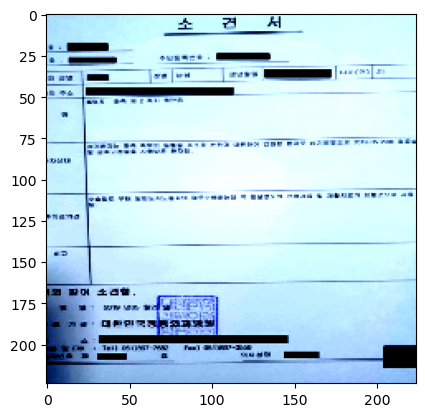

In [63]:
# 저장한 이미지 확인
plt.imshow(tst_img[10])
plt.show()

In [93]:
tst_df = pd.DataFrame({
    # 'img' : tst_img,
    'target' : tst_target_list,
    'predict' : tst_preds_list
})

In [94]:
len(tst_df['target'])

8792

In [95]:
# 맞춘 개수
(tst_df['predict'] == tst_df['target']).sum()

8238

In [96]:
# 틀린 개수
(~(tst_df['predict'] == tst_df['target'])).sum()

554

In [97]:
(~(tst_df['predict'] != tst_df['target'])).sum()/((tst_df['predict'] == tst_df['target']).sum()+(~(tst_df['predict'] == tst_df['target'])).sum())

0.9369881710646042

In [98]:
tst_df[~(tst_df['predict'] == tst_df['target'])]

,target,predict
23,7,3
29,3,7
43,11,10
68,7,3
97,14,4
...,...,...
8733,14,3
8734,7,12
8735,7,3
8763,3,14


In [ ]:
i = pd.read_csv('../datasets_fin/test.csv')
i

In [ ]:
# 각 예측의 이미지 id 추가
tst_df['ID'] = list(i['ID']) * 67

In [ ]:
def get_item(idx):
    image, target, predict, name = tst_df.loc[idx,]
    img = np.array(Image.open(os.path.join("../datasets_fin/train/", name)))

    # img = trn_transform(image=img)['image']
    return img, target, name, predict, image

In [99]:
tst_df[(tst_df['predict'] != tst_df['target'])].value_counts('target')

target
3     179
7     145
14     80
11     60
4      37
6      14
12     11
8       8
0       7
9       5
2       4
15      2
5       1
10      1
dtype: int64

In [100]:
tst_df[(tst_df['predict'] != tst_df['target'])].value_counts('predict')

predict
7     154
3      83
10     73
14     71
4      58
1      51
12     37
13     13
16      5
11      4
5       2
9       2
6       1
dtype: int64

In [102]:
qw = tst_df[(tst_df['predict'] != tst_df['target'])&(tst_df['target'] == 7)]
qw

,target,predict
23,7,3
68,7,3
99,7,12
180,7,3
225,7,3
...,...,...
8546,7,3
8577,7,10
8658,7,3
8734,7,12


In [103]:
qw.value_counts()

target  predict
7       3          80
        12         34
        1          16
        14         10
        4           2
        10          2
        6           1
dtype: int64

In [ ]:
# # target과 predict가 일치하지 않는 이미지 시각화, target별로 확인
# check_target = 7
# for idx in tst_df[(tst_df['predict'] != tst_df['target'])&(tst_df['target'] == check_target)].index:
#     img, target, name, predict, image = get_item(idx)
#     print(img.shape, name, target, predict)
#     # plt.imshow(img) #원본 이미지
#     # plt.show()
#     plt.imshow(image) #학습에 사용된 이미지
#     plt.show()
#     # print(idx)

In [ ]:
qw = tst_df[tst_df['target'] == 13]
qw

In [ ]:
(qw['predict'] != qw['target']).sum()